In [101]:
# Imports 
import time
import os
import re
import json
import collections

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from fuzzywuzzy import fuzz
import pandas as pd
# Load your usual SpaCy model (one of SpaCy English models)
import spacy
nlp = spacy.load('en')

# Add neural coref to SpaCy's pipe
import neuralcoref
neuralcoref.add_to_pipe(nlp, blacklist=True)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/nuwandavek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [224]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import torch.nn.functional as nnf
tokenizer = BertTokenizer.from_pretrained("monologg/bert-base-cased-goemotions-original")
model = BertForSequenceClassification.from_pretrained("monologg/bert-base-cased-goemotions-original", return_dict=True)
import numpy as np
emotions = ['admiration','amusement','anger','annoyance','approval','caring','confusion','curiosity',\
            'desire','disappointment','disapproval','disgust','embarrassment','excitement','fear',\
            'gratitude','grief','joy','love','nervousness','optimism','pride','realization','relief',\
            'remorse','sadness','surprise','neutral']
reduced_emotions = {
    'admiration' : 'pos',
 'amusement' : 'pos',
 'anger' : 'neg',
 'annoyance' : 'neg',
 'approval' : 'pos',
 'caring' : 'pos',
 'confusion' : 'amb',
 'curiosity' : 'amb',
 'desire' : 'pos',
 'disappointment' : 'neg',
 'disapproval' : 'neg',
 'disgust' : 'neg',
 'embarrassment' : 'neg',
 'excitement' : 'pos',
 'fear' : 'neg',
 'gratitude' : 'pos',
 'grief' : 'neg',
 'joy' : 'pos',
 'love' : 'pos',
 'nervousness' : 'neg',
 'optimism' : 'pos',
 'pride' : 'pos',
 'realization' : 'amb',
 'relief' : 'pos',
 'remorse' : 'neg',
 'sadness' : 'neg',
 'surprise' : 'amb',
 'neutral' : 'amb'
}

In [90]:
'''
A class reresenting a mention of some entity. 
It consists of a text string, starting and ending indices
of the text span and a paragraph and sentence id. 
'''
class Mention:
    def __init__(self, text, start, end, par_id, sent_id, global_sentence_id):
        self.text =  text
        self.start = start
        self.end = end
        self.par_id = par_id
        self.sent_id = sent_id
        self.global_sentence_id = global_sentence_id
        self.POS = []
        self.deps = set()
        
    def __repr__(self):
        rep = "Mention in par " + str(self.par_id) + " Sentence " \
              + str(self.sent_id) + "(Global Sentence "+self.global_sentence_id + ") text:pip install fuzzywuzzy[speedup]\n" + self.text
        return rep

'''
A class reresenting a character. 
It consists of a list of mentions, a set of aliases, 
a list of verbs that the character is the actor of (agent),
a list of verbs that the character is the receiver of (patient),
a list of adjectives that the character is described with (description).  
'''
class Character:
    def __init__(self, book, mainName):
        self.book = book
        self.mainName = mainName
        self.mentions = []
        self.unique_sents = {}
        self.aliases = set()
        self.agent = {}
        self.patient = []
        self.description = []
        
    def __repr__(self):
        rep = "Character: " + self.mainName + "\n"
        return rep
    
    '''
    Add a mention of the character to a list of mentions.
    '''
    def update_mention(self, mention):
        self.mentions.append(mention)
        self.aliases.update([mention.text.lower()])
        
    '''
    Match POS tags with character mentions
    '''
    def get_POS(self):
        for mention in self.mentions:
            span = range(mention.start, mention.end)
            for loc in span:
                mention.POS.append(self.book.pars[mention.par_id].POS_tags[loc])
                mention.deps.update([mention.POS[-1]['dep']])
                
    def get_unique_sent_mentions(self):
        for mention in self.mentions:
            self.unique_sents[(mention.par_id, mention.sent_id, mention.global_sentence_id)] = \
            self.book.pars[mention.par_id].sents[mention.sent_id].text
                
    '''
    Function to find the verbs in sentences in which the character is mentioned 
    as the nsubj.
    '''
    def get_agent_verbs(self):
        for mention in self.mentions:
            verb = None
            if 'nsubj' in mention.deps:
                sent_POS_parse = self.book.pars[mention.par_id].sents[mention.sent_id].POS_tags
                for POS in sent_POS_parse:
                    if POS['dep'] == 'ROOT':
                        verb = POS['text']
                        # Get location tuple (paragraph, sentence, local idx)
                        global_loc = (mention.par_id, mention.sent_id, POS['loc'])
                if verb:
                    self.agent[global_loc] = verb
                    
        

class Sentence:
    def __init__(self, book, par, text, sent_id, bound):
        # Parent objects
        self.book = book
        self.par = par
        # starting and ending boundary for the sentence (relative to the paragraph)
        self.start = bound[0]
        self.end = bound[1]
        # Global starting and ending indices
        self.globalStart = self.par.start + self.start
        self.globalEnd = self.par.start + self.end 
        self.text = text
        self.sent_id = sent_id
        self.POS_tags = []
        
    def __repr__(self):
        rep = self.book.fileName + "\nParagraph " + str(self.par.par_id) \
        + "\nSentence " + str(self.sent_id) + " start " + str(self.start) \
        + " end " + str(self.end) + "\ntext:\n" + self.text
        return rep
        
'''
A class for a paragraph.
'''
class Paragraph:
    def __init__(self, book, text, par_id, bound):
        # Starting and ending indices for the paragraph
        self.start = bound[0]
        self.end = bound[1]
        # Refers to book parent object
        self.book = book
        # paragraph text
        self.text = text
        # paragraph index
        self.par_id = par_id
        # bool idnicating whether coref wroked
        self.has_coref = False
        # coref cluster list
        self.coref_clusts = []
        # list of sentences
        self.sents = []
        self.number_of_sentences = 0
        self.sent_bounds = []
        self.POS_tags = []
        
    def __repr__(self):
        rep = self.book.fileName + "\nParagraph " + str(self.par_id) + "\ntext:\n" + self.text
        return rep
    
    '''
    Split text into sentences
    '''
    def parse_into_sentences(self):
        doc = nlp(self.text)
        sentences = [sent for sent in doc.sents]
        self.sents = [Sentence(self.book, self, sent.text, 
                               sent_id, (sent.start, sent.end)) 
                      for sent_id, sent in enumerate(sentences)]
        self.number_of_sentences = len(sentences)
        
        
    def run_coref_POS(self):
        # Get coreference tags:
        doc = nlp(self.text)
        # Update whether the coref parser returned results
        self.has_coref = doc._.has_coref
        if doc._.has_coref:
            self.coref_clusts = doc._.coref_clusters
            self.book.parse_coref_clusts(self)
        # Get POS tags:

        # this uses the pretrained BERT model:
        # book[idx]["POS_tags"] = nlp_token_class(sentence)

        # For now we will use Spacy pos tagging because it gives us more fine-grained labels:
        self.POS_tags = []
        # Add POS tags to list for paragraph and for each individual sentence
        for token_id in range(len(doc)):
            token = doc[token_id]
            sent_id = 0
            for sent in self.sents:
                if ((token_id >= sent.start) and (token_id <= sent.end)):
                        sent_id = sent.sent_id
            self.sents[sent_id].POS_tags.append({
                'loc' : token_id,
                'text' : token.text,
                'lemma' : token.lemma_,
                'pos' : token.pos_, 
                'tag' : token.tag_, 
                'dep' : token.dep_})
            self.POS_tags.append({
                'loc' : token_id,
                'text' : token.text,
                'lemma' : token.lemma_,
                'pos' : token.pos_, 
                'tag' : token.tag_, 
                'dep' : token.dep_})

'''
A class representing a book.
'''        
class Book:
    def __init__(self, dataPath, fileName):
        self.dataPath = dataPath
        self.fileName = fileName
        self.text = ''
        self.characters = {}
        self.char_mention_counts = collections.Counter()
        self.top_characters = {}
        self.pars = []
        self.read_file()
    
    '''
    Read the text of the book from a txt file.
    '''
    def read_file(self):
        with open(os.path.join(self.dataPath, self.fileName), "r") as txtFile:
            self.text = txtFile.read()
        
    '''
    Break the text into paragraphs.
    '''
    def parse_into_pars(self):
        # split on newlines followed by space
        pars = re.split('\n\s', self.text)   
#         par_bounds = [0]
#         par_bounds += [m.start(0) for m in re.finditer('\n\s', self.text)]
#         par_bounds.append(len(self.text) - 1)
        # Replace newline chars
        pars = [par.replace("\n", " ") for par in pars]
        # Remove empty pars
        pars = [par for par in pars if len(par) > 0]
        
        #Preprocess "paragraphs" that are actually quotes or single lined text
        final_pars = []
        for p,paragraph in enumerate(pars):
            
            if paragraph.count(".")<5:
                if p==0:
                    final_pars.append(paragraph)
                else:
                    final_pars[-1] = final_pars[-1] + " " + paragraph
            else:
                final_pars.append(paragraph)
                
                
        par_bounds = []
        par_loc = 0
        for par in final_pars:
            par_bounds.append(par_loc)
            par_loc += len(par)
        par_bounds.append(par_loc)
        
        
        # Convert each paragraph into a Paragraph
        self.pars = [Paragraph(self, par, par_id, (par_bounds[par_id],
                                                   par_bounds[par_id+1])) 
                     for par_id, par in enumerate(final_pars)]
        
    '''
    Parse the coreference clusters returned from the parsing of a paragraph
    '''
    def parse_coref_clusts(self, par):
        clustList = par.coref_clusts
        # Iterate over the coreference clusters
        for idx, cluster in enumerate(clustList):
            # get the main cluster identity
            mainSpan = cluster.main.text.lower()
            # If a character object does not yet exist, create one
            max_fuzz = 70
            max_fuzz_char = ''
            for ch in self.characters:
                pr = fuzz.partial_ratio(mainSpan, ch)
                if pr>max_fuzz:
                    max_fuzz = pr
                    max_fuzz_char = ch
            if max_fuzz>70:
                # It is already present
                character = self.characters[max_fuzz_char]
            else:
                character = Character(self, mainSpan)
                # Add it to the dict of characters
                self.characters[mainSpan] = character
                
            for mention in cluster.mentions:
                # figure out which sentence the mention belongs to
                sent_id = 0
                for sent in par.sents:
                    if ((mention.start >= sent.start) and (mention.end <= sent.end)):
                        sent_id = sent.sent_id
                # create a mention object and add it to the character object
                global_sentence_id = par.sent_bounds[0] + sent_id
                mention = Mention(mention.text, mention.start, mention.end, par.par_id, sent_id, global_sentence_id)
                character.update_mention(mention)
                self.char_mention_counts[character.mainName] += 1
                
    def get_top_characters(self, n=5):
        # Get n most mentioned characters
        self.top_characters = self.char_mention_counts.most_common()[:n]
        self.top_characters = {character[0] : self.characters[character[0]]
                               for character in self.top_characters}
                
    def get_global_sentence_bounds(self):
        sentence_begin = 0
        for par in self.pars:
            sentence_end = sentence_begin + par.number_of_sentences - 1
            par.sent_bounds = [sentence_begin, sentence_end]
            
            sentence_begin = sentence_end+1
        
    def parse_text(self):
        self.parse_into_pars()
        for par in self.pars:
            par.parse_into_sentences()
        self.get_global_sentence_bounds()
        for par in self.pars:
            par.run_coref_POS()
        for characterName, character in self.characters.items():
            character.get_POS()
            character.get_agent_verbs()
            character.get_unique_sent_mentions()
        self.get_top_characters()
        

In [91]:
# Define Paths and fileNames:
dataPath = "../datasets/Gutenberg/txt/"
# fileName = "Herman Melville___Bartleby, The Scrivener.txt"
# title = "Herman Melville___Bartleby, The Scrivener"
title = "Charles Dickens___A Christmas Carol"
fileName = f"{title}.txt"
stopwordsFileName = "StopWords/jockers.stopwords"
outFileName = f'{title}_sentences.json'

In [92]:
b = Book(dataPath, fileName)
b.parse_text()

In [225]:
def get_emotion(text):
    inputs = tokenizer(text, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits
    probs = nnf.softmax(logits, dim=1).data.numpy().squeeze()
    emotion = emotions[np.argmax(probs)]
    emo_prob = np.max(probs)
    mini_emotion = reduced_emotions[emotion]
    return  emotion, mini_emotion, emo_prob, probs

In [226]:
emo_df = pd.DataFrame()
for character in b.top_characters:
    char_emotion = []
    for loc, sent in b.top_characters[character].unique_sents.items():
        emotion, mini_emotion, emo_prob, probs = get_emotion(sent)
        char_emotion.append([character, loc[0],  loc[1], loc[2], emotion, mini_emotion, emo_prob])
    char_df = pd.DataFrame(char_emotion, columns =['character', 'paragraph_id','sent_id','global_sent_id', \
                                                  'emotion', 'mini_emotion','emo_prob'])
    emo_df = pd.concat([emo_df,char_df])

## Plotting

In [227]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

In [228]:
emo_df.head()

,character,paragraph_id,sent_id,global_sent_id,emotion,mini_emotion,emo_prob
0,scrooge,1,1,21,neutral,amb,0.999984
1,scrooge,1,2,22,neutral,amb,0.612577
2,scrooge,2,6,37,neutral,amb,0.999965
3,scrooge,2,36,67,neutral,amb,0.995647
4,scrooge,2,43,74,neutral,amb,0.984656


In [229]:
emo_df['glob_sent_ratio'] = emo_df['global_sent_id']/b.pars[-1].sent_bounds[1]
emo_df['glob_sent_grp'] = (emo_df['glob_sent_ratio']  / 0.025).apply(int)
emo_df.groupby('character').count()

,paragraph_id,sent_id,global_sent_id,emotion,mini_emotion,emo_prob,glob_sent_ratio,glob_sent_grp
character,,,,,,,,
bob,53,53,53,53,53,53,53,53
it,269,269,269,269,269,269,269,269
scrooge,527,527,527,527,527,527,527,527
the cricket on the hearth,119,119,119,119,119,119,119,119
the ghost,79,79,79,79,79,79,79,79


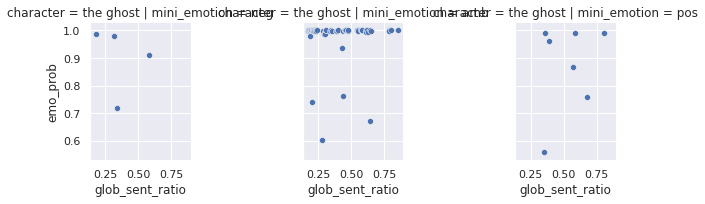

In [268]:
ed = emo_df[emo_df['character'].isin(['the ghost'])]
# ed = ed[~ed['mini_emotion'].isin(['neutral'])]
# Initialize a grid of plots with an Axes for each walk
grid = sns.FacetGrid(ed, row="character",col="mini_emotion",# palette="tab20c",
                     )#, 
#                     width=1.5)

# Draw a line plot to show the trajectory of each random walk
# grid.map(plt.plot, "glob_sent_ratio", "emo_prob", marker="o")
grid.map(sns.scatterplot, "glob_sent_ratio", "emo_prob")


In [269]:
ged = ed.groupby(['character','glob_sent_grp','mini_emotion']).agg({'global_sent_id':'count'})
ged = ged/ged.groupby(level=[0,1]).sum()
ged = ged.reset_index()

In [270]:
gedd = ged.pivot(index=['character','glob_sent_grp'], columns='mini_emotion', values='global_sent_id').fillna(0).reset_index()

In [271]:
ged.head()

,character,glob_sent_grp,mini_emotion,global_sent_id
0,the ghost,7,amb,0.9
1,the ghost,7,neg,0.1
2,the ghost,8,amb,1.0
3,the ghost,9,amb,1.0
4,the ghost,11,amb,1.0


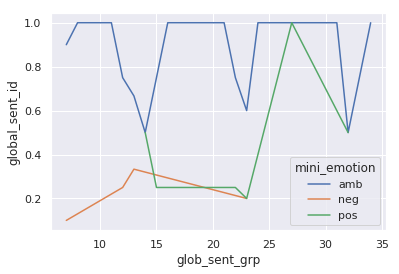

In [272]:
sns.lineplot(x="glob_sent_grp", y="global_sent_id",
             hue="mini_emotion",
             data=ged)

/home/nuwandavek/anaconda3/envs/peace/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:2062: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/home/nuwandavek/anaconda3/envs/peace/lib/python3.8/site-packages/matplotlib/axes/_base.py:248: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/home/nuwandavek/anaconda3/envs/peace/lib/python3.8/site-packages/matplotlib/axes/_base.py:250: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


Text(0,0.5,'Net Emotion Proportion')

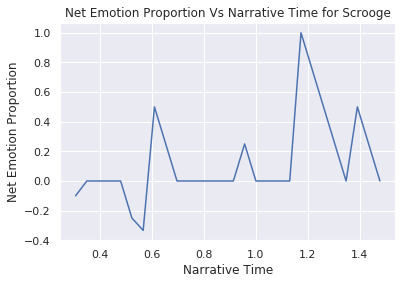

In [273]:
plt.plot(gedd['glob_sent_grp']/(len(gedd)+1),gedd['pos']-gedd['neg'])
plt.title('Net Emotion Proportion Vs Narrative Time for Scrooge')
plt.xlabel('Narrative Time')
plt.ylabel('Net Emotion Proportion')

In [ ]:
# '''
# Split text into sentences
# '''
# def parse_into_sentences(fileName):
#     with open(os.path.join(dataPath, fileName), "r") as txtFile:
#         doc = txtFile.read()
#     sentences = re.split('\.|!|\?', doc)   
#     sentences = [sentence.replace("\n", " ") for sentence in sentences]
#     return sentences
# '''
# Split text into paragraphs
# '''
# def parse_into_pars(fileName):
#     with open(os.path.join(dataPath, fileName), "r") as txtFile:
#         doc = txtFile.read()
#     pars = re.split('\n\s', doc)   
#     pars = [par.replace("\n", " ") for par in pars]
#     return pars
# '''
# Create list of stop words (currently not used)
# '''
# def read_stopwords(filename):
#     stopwords={}
#     with open(filename) as file:
#         for line in file:
#             stopwords[line.rstrip()]=1
#     return stopwords

# '''
# Clean sentences by removing trailing punctuation on words, 
# and converting to lowercase
# '''
# def clean_sentences(sentences, charsTOStrip = '\"\', '):
#     texts = [
#         [word.strip(charsTOStrip) for word in sentence.lower().split()]
#         for sentence in sentences]
#     return texts

In [ ]:
# '''
# Convert list of neuralcoref.neuralcoref.Cluster objects 
# to list of dicts so that we can serialize it. 
# '''
# def convert_clust_to_list_dict(clustList):
#     dictList = []
#     characters = {character : {
#     "aliases" : set(),
#     "agent" : [],
#     "patient" : [],
#     "description" : [],
#     } for character in top_characters}
    
#     for idx, cluster in enumerate(clustList):
#         mainSpan = cluster.main
#         dictList.append({mainSpan.text.lower() : [{'start' : mention.start, 'end': mention.end, 'text' : mention.text}
#                                            for mention in cluster.mentions]})
#         characters[mainSpan.text.lower()] += 1
#     return dictList, characters

In [ ]:
# # Creating book data structure that we will use.
# # For now it is just a dict, but maybe we can make it a class
# def create_book_struct(fileName):
    
#     characters = collections.Counter()
    
#     time_start = time.time()

#     # break file into paragraphs
#     pars = parse_into_pars(fileName)
#     #parse_into_sentences(fileName)

#     # initialize book obj
#     book = {}
#     # Iterate over each sentence and 
#     for idx, sentence in enumerate(sentences):

#         # Get sentence id and text
#         book[idx] = {}
#         book[idx]['text'] = sentence

#         # Get coreference tags:
#         doc = nlp(sentence)
#         book[idx]['has_coref'] = doc._.has_coref
#         if doc._.has_coref:
#             coref_clusts, chars = convert_clust_to_list_dict(doc._.coref_clusters)
#             book[idx]['coref_clusts'] = coref_clusts
            
#             characters += chars
#         else:
#             book[idx]['coref_clusts'] = []

#         # Get POS tags:

#         # this uses the pretrained BERT model:
#         # book[idx]["POS_tags"] = nlp_token_class(sentence)

#         # For now we will use Spacy pos tagging because it gives us more fine-grained labels:
#         book[idx]["POS_tags"] = []
#         for token in doc:
#             book[idx]["POS_tags"].append({
#                 'text' : token.text,
#                 'lemma' : token.lemma_,
#                 'pos' : token.pos_, 
#                 'tag' : token.tag_, 
#                 'dep' : token.dep_})
#     time_end = time.time()
#     print("Parsing book took ", round(time_end - time_start, 2), " secs")
#     return book, characters

In [ ]:
# book, characters = create_book_struct(fileName)

In [ ]:
# def write_book_to_disk(book, outFileName):
#     with open (os.path.join(dataPath, outFileName), 'w') as outFile:
#         json.dump(book, outFile, separators=(',', ':'), indent=4)

In [ ]:
# write_book_to_disk(book, outFileName)

In [ ]:
# # Only get top n most mentioned characters. 
# # Probably we should replace this with some kind of 
# # filter based on the min number of mentions
# most_common_n = 20
# top_characters = characters.most_common()[:most_common_n]
# top_characters = [top_character[0] for top_character in top_characters]

In [ ]:
# doc = nlp('''
# I am a rather elderly man.  The nature of my avocations for the last
# thirty years has brought me into more than ordinary contact with what
# would seem an interesting and somewhat singular set of men, of whom as
# yet nothing that I know of has ever been written:--I mean the
# law-copyists or scriveners.  I have known very many of them,
# professionally and privately, and if I pleased, could relate divers
# histories, at which good-natured gentlemen might smile, and sentimental
# souls might weep.  But I waive the biographies of all other scriveners
# for a few passages in the life of Bartleby, who was a scrivener of the
# strangest I ever saw or heard of.  While of other law-copyists I might
# write the complete life, of Bartleby nothing of that sort can be done.
# I believe that no materials exist for a full and satisfactory biography
# of this man.  It is an irreparable loss to literature.  Bartleby was one
# of those beings of whom nothing is ascertainable, except from the
# original sources, and in his case those are very small.  What my own
# astonished eyes saw of Bartleby, _that_ is all I know of him, except,
# indeed, one vague report which will appear in the sequel.
# ''')

# for token in doc:
#     print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
#             token.shape_, token.is_alpha)

In [19]:
from transformers import AutoTokenizer, AutoModelWithLMHead

tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-emotion")

model = AutoModelWithLMHead.from_pretrained("mrm8488/t5-base-finetuned-emotion")


/home/dmac/Documents/MIMS Coursework/Info 190 Comp Hum/Project/code/.env/lib/python3.8/site-packages/transformers/modeling_auto.py:781: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


/home/dmac/Documents/MIMS Coursework/Info 190 Comp Hum/Project/code/.env/lib/python3.8/site-packages/transformers/tokenization_t5.py:184: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(


'sadness'

tensor([[   0, 3922]])

In [97]:
b.characters['i'].agent

{(2, 0, 1): 'am',
 (2, 1, 52): 'mean',
 (2, 2, 63): 'known',
 (2, 3, 101): 'waive',
 (2, 4, 141): 'write',
 (2, 5, 157): 'believe',
 (2, 8, 215): 'saw',
 (7, 0, 11): 'had',
 (7, 6, 195): 'seemed',
 (7, 7, 222): 'are',
 (12, 13, 358): 'was',
 (12, 14, 402): 'have',
 (12, 18, 538): 'had',
 (12, 23, 642): 'reasoned',
 (12, 24, 654): 'was',
 (12, 26, 708): 'presented',
 (12, 27, 746): 'thought',
 (12, 29, 769): 'believe',
 (13, 0, 10): 'had',
 (13, 1, 20): 'was',
 (13, 4, 108): 'spread',
 (17, 0, 9): 'engaged',
 (17, 1, 25): 'sedate',
 (18, 0, 3): 'stated',
 (18, 1, 38): 'threw',
 (18, 2, 49): 'resolved',
 (18, 4, 91): 'placed',
 (18, 6, 193): 'procured',
 (20, 3, 74): 'imagine',
 (20, 4, 113): 'say',
 (22, 0, 6): 'sit',
 (22, 1, 60): 'replied',
 (23, 0, 1): 'sat',
 (23, 2, 43): 'assume',
 (23, 3, 61): 'prefer',
 (24, 0, 6): 'echoed',
 (24, 1, 27): 'mean',
 (24, 2, 30): 'Are',
 (24, 3, 48): 'take',
 (25, 0, 8): 'said',
 (26, 0, 1): 'looked',
 (26, 4, 51): 'been',
 (26, 5, 78): 'have',
 (26